In [1]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List


import sys
sys.path.append('./datasets/')
from datasets.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    


In [2]:
print(torch.__version__)




2.0.1+cu117


In [3]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 50
pickle_name = "mnist-epoch-"+str(epoch_total)

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [6]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [7]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in test_datasets]


In [8]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x00000195AA33B7F0>, <torch.utils.data.dataloader.DataLoader object at 0x00000195AA33AAD0>, <torch.utils.data.dataloader.DataLoader object at 0x00000195AA33A050>, <torch.utils.data.dataloader.DataLoader object at 0x00000195AA339F60>, <torch.utils.data.dataloader.DataLoader object at 0x00000195AA339C30>]
2000


In [9]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

ypred_test = []
ylabels_test = []

In [10]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0



        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = correct/total
        print("DEBUG:",self.node_id, self.train_accuracy, correct, total)
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            
            ypred_test.append(predicted.cpu())
            ylabels_test.append(true_labels.cpu())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
        
        #print(predictions)

        predictions2 = np.concatenate(predictions)
        labels2 = np.concatenate(labels)
        self.f1_score= f1_score(labels2, predictions2, average="weighted")
        self.test_accuracy = correct/total
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    def f1pred(self):
        pred_test = []
        y_label = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            y=self.network(data_x.to(device))
            
            y = torch.argmax(y, dim=1)
            pred_test.append(y)
            
            data_y = torch.argmax(data_y, dim=1)
            y_label.append(data_y)
        pred_test = torch.cat(pred_test)
        y_label = torch.cat(y_label)
        return pred_test, y_label
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])
    







In [11]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
ypred_test = []
ylabels_test = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [12]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc = []
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
        node.testing()
        #test_losses.append(node.test_loss)
        #print("Node Test Accuracy", node.test_accuracy)
        #print("Node Test loss", node.test_loss)
        #print("Node F1_Score ", node.f1_score)
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG: 0 0.09558333333333334 1147 12000
DEBUG: 1 0.10675 1281 12000
DEBUG: 2 0.07358333333333333 883 12000
DEBUG: 3 0.09416666666666666 1130 12000
DEBUG: 4 0.10725 1287 12000


  2%|▏         | 1/50 [00:11<09:22, 11.49s/it]

DEBUG: 0 0.09133333333333334 1096 12000
DEBUG: 1 0.09241666666666666 1109 12000
DEBUG: 2 0.09191666666666666 1103 12000
DEBUG: 3 0.09783333333333333 1174 12000
DEBUG: 4 0.096 1152 12000


  4%|▍         | 2/50 [00:20<07:56,  9.92s/it]

DEBUG: 0 0.12108333333333333 1453 12000
DEBUG: 1 0.1195 1434 12000
DEBUG: 2 0.12425 1491 12000
DEBUG: 3 0.12725 1527 12000
DEBUG: 4 0.12533333333333332 1504 12000


  6%|▌         | 3/50 [00:29<07:33,  9.65s/it]

DEBUG: 0 0.2604166666666667 3125 12000
DEBUG: 1 0.2615 3138 12000
DEBUG: 2 0.25858333333333333 3103 12000
DEBUG: 3 0.2618333333333333 3142 12000
DEBUG: 4 0.2645 3174 12000


  8%|▊         | 4/50 [00:38<07:15,  9.47s/it]

DEBUG: 0 0.41108333333333336 4933 12000
DEBUG: 1 0.4215833333333333 5059 12000
DEBUG: 2 0.415 4980 12000
DEBUG: 3 0.41458333333333336 4975 12000
DEBUG: 4 0.41733333333333333 5008 12000


 10%|█         | 5/50 [00:47<06:57,  9.28s/it]

DEBUG: 0 0.47375 5685 12000
DEBUG: 1 0.486 5832 12000
DEBUG: 2 0.48083333333333333 5770 12000
DEBUG: 3 0.486 5832 12000
DEBUG: 4 0.48741666666666666 5849 12000


 12%|█▏        | 6/50 [00:56<06:45,  9.23s/it]

DEBUG: 0 0.5144166666666666 6173 12000
DEBUG: 1 0.5254166666666666 6305 12000
DEBUG: 2 0.5245833333333333 6295 12000
DEBUG: 3 0.5275833333333333 6331 12000
DEBUG: 4 0.5286666666666666 6344 12000


 14%|█▍        | 7/50 [01:05<06:32,  9.12s/it]

DEBUG: 0 0.5440833333333334 6529 12000
DEBUG: 1 0.5573333333333333 6688 12000
DEBUG: 2 0.5585833333333333 6703 12000
DEBUG: 3 0.557 6684 12000
DEBUG: 4 0.5583333333333333 6700 12000


 16%|█▌        | 8/50 [01:14<06:21,  9.09s/it]

DEBUG: 0 0.57175 6861 12000
DEBUG: 1 0.584 7008 12000
DEBUG: 2 0.5853333333333334 7024 12000
DEBUG: 3 0.5845 7014 12000
DEBUG: 4 0.5840833333333333 7009 12000


 18%|█▊        | 9/50 [01:23<06:11,  9.05s/it]

DEBUG: 0 0.5933333333333334 7120 12000
DEBUG: 1 0.6054166666666667 7265 12000
DEBUG: 2 0.6076666666666667 7292 12000
DEBUG: 3 0.6049166666666667 7259 12000
DEBUG: 4 0.6059166666666667 7271 12000


 20%|██        | 10/50 [01:34<06:27,  9.68s/it]

DEBUG: 0 0.6126666666666667 7352 12000
DEBUG: 1 0.626 7512 12000
DEBUG: 2 0.6281666666666667 7538 12000
DEBUG: 3 0.624 7488 12000
DEBUG: 4 0.62525 7503 12000


 22%|██▏       | 11/50 [01:43<06:09,  9.48s/it]

DEBUG: 0 0.633 7596 12000
DEBUG: 1 0.6440833333333333 7729 12000
DEBUG: 2 0.6459166666666667 7751 12000
DEBUG: 3 0.63975 7677 12000
DEBUG: 4 0.6420833333333333 7705 12000


 24%|██▍       | 12/50 [01:52<05:53,  9.30s/it]

DEBUG: 0 0.65025 7803 12000
DEBUG: 1 0.6591666666666667 7910 12000
DEBUG: 2 0.6604166666666667 7925 12000
DEBUG: 3 0.65475 7857 12000
DEBUG: 4 0.6583333333333333 7900 12000


 26%|██▌       | 13/50 [02:01<05:41,  9.23s/it]

DEBUG: 0 0.6634166666666667 7961 12000
DEBUG: 1 0.6725 8070 12000
DEBUG: 2 0.6748333333333333 8098 12000
DEBUG: 3 0.66925 8031 12000
DEBUG: 4 0.6731666666666667 8078 12000


 28%|██▊       | 14/50 [02:10<05:28,  9.14s/it]

DEBUG: 0 0.67425 8091 12000
DEBUG: 1 0.6846666666666666 8216 12000
DEBUG: 2 0.68625 8235 12000
DEBUG: 3 0.68225 8187 12000
DEBUG: 4 0.6845 8214 12000


 30%|███       | 15/50 [02:19<05:16,  9.05s/it]

DEBUG: 0 0.685 8220 12000
DEBUG: 1 0.6935833333333333 8323 12000
DEBUG: 2 0.6971666666666667 8366 12000
DEBUG: 3 0.6926666666666667 8312 12000
DEBUG: 4 0.6964166666666667 8357 12000


 32%|███▏      | 16/50 [02:28<05:06,  9.02s/it]

DEBUG: 0 0.6939166666666666 8327 12000
DEBUG: 1 0.7016666666666667 8420 12000
DEBUG: 2 0.7070833333333333 8485 12000
DEBUG: 3 0.7015 8418 12000
DEBUG: 4 0.7053333333333334 8464 12000


 34%|███▍      | 17/50 [02:37<04:56,  8.98s/it]

DEBUG: 0 0.70225 8427 12000
DEBUG: 1 0.7086666666666667 8504 12000
DEBUG: 2 0.7139166666666666 8567 12000
DEBUG: 3 0.71 8520 12000
DEBUG: 4 0.7121666666666666 8546 12000


 36%|███▌      | 18/50 [02:46<04:47,  8.97s/it]

DEBUG: 0 0.7094166666666667 8513 12000
DEBUG: 1 0.7159166666666666 8591 12000
DEBUG: 2 0.7221666666666666 8666 12000
DEBUG: 3 0.71625 8595 12000
DEBUG: 4 0.7185833333333334 8623 12000


 38%|███▊      | 19/50 [02:55<04:38,  9.00s/it]

DEBUG: 0 0.7170833333333333 8605 12000
DEBUG: 1 0.7213333333333334 8656 12000
DEBUG: 2 0.7293333333333333 8752 12000
DEBUG: 3 0.7238333333333333 8686 12000
DEBUG: 4 0.7253333333333334 8704 12000


 40%|████      | 20/50 [03:04<04:28,  8.96s/it]

DEBUG: 0 0.7219166666666667 8663 12000
DEBUG: 1 0.7274166666666667 8729 12000
DEBUG: 2 0.7355 8826 12000
DEBUG: 3 0.7285833333333334 8743 12000
DEBUG: 4 0.7303333333333333 8764 12000


 42%|████▏     | 21/50 [03:13<04:22,  9.04s/it]

DEBUG: 0 0.7269166666666667 8723 12000
DEBUG: 1 0.7345833333333334 8815 12000
DEBUG: 2 0.7415 8898 12000
DEBUG: 3 0.7345 8814 12000
DEBUG: 4 0.73525 8823 12000


 44%|████▍     | 22/50 [03:22<04:14,  9.09s/it]

DEBUG: 0 0.7335 8802 12000
DEBUG: 1 0.7399166666666667 8879 12000
DEBUG: 2 0.7464166666666666 8957 12000
DEBUG: 3 0.7396666666666667 8876 12000
DEBUG: 4 0.7405 8886 12000


 46%|████▌     | 23/50 [03:31<04:05,  9.10s/it]

DEBUG: 0 0.7384166666666667 8861 12000
DEBUG: 1 0.7444166666666666 8933 12000
DEBUG: 2 0.7516666666666667 9020 12000
DEBUG: 3 0.74475 8937 12000
DEBUG: 4 0.74725 8967 12000


 48%|████▊     | 24/50 [03:41<03:57,  9.13s/it]

DEBUG: 0 0.7428333333333333 8914 12000
DEBUG: 1 0.75 9000 12000
DEBUG: 2 0.75575 9069 12000
DEBUG: 3 0.7505 9006 12000
DEBUG: 4 0.7525833333333334 9031 12000


 50%|█████     | 25/50 [03:50<03:48,  9.13s/it]

DEBUG: 0 0.7490833333333333 8989 12000
DEBUG: 1 0.7559166666666667 9071 12000
DEBUG: 2 0.7613333333333333 9136 12000
DEBUG: 3 0.7551666666666667 9062 12000
DEBUG: 4 0.7584166666666666 9101 12000


 52%|█████▏    | 26/50 [03:59<03:39,  9.13s/it]

DEBUG: 0 0.7551666666666667 9062 12000
DEBUG: 1 0.7598333333333334 9118 12000
DEBUG: 2 0.76625 9195 12000
DEBUG: 3 0.7605 9126 12000
DEBUG: 4 0.7626666666666667 9152 12000


 54%|█████▍    | 27/50 [04:08<03:30,  9.15s/it]

DEBUG: 0 0.7605 9126 12000
DEBUG: 1 0.765 9180 12000
DEBUG: 2 0.7704166666666666 9245 12000
DEBUG: 3 0.7645833333333333 9175 12000
DEBUG: 4 0.7670833333333333 9205 12000


 56%|█████▌    | 28/50 [04:17<03:20,  9.12s/it]

DEBUG: 0 0.7658333333333334 9190 12000
DEBUG: 1 0.76975 9237 12000
DEBUG: 2 0.7749166666666667 9299 12000
DEBUG: 3 0.7675833333333333 9211 12000
DEBUG: 4 0.7708333333333334 9250 12000


 58%|█████▊    | 29/50 [04:26<03:11,  9.11s/it]

DEBUG: 0 0.7705 9246 12000
DEBUG: 1 0.7745 9294 12000
DEBUG: 2 0.7775833333333333 9331 12000
DEBUG: 3 0.7713333333333333 9256 12000
DEBUG: 4 0.7745833333333333 9295 12000


 60%|██████    | 30/50 [04:35<03:00,  9.05s/it]

DEBUG: 0 0.7735833333333333 9283 12000
DEBUG: 1 0.77875 9345 12000
DEBUG: 2 0.78075 9369 12000
DEBUG: 3 0.7764166666666666 9317 12000
DEBUG: 4 0.7783333333333333 9340 12000


 62%|██████▏   | 31/50 [04:44<02:52,  9.08s/it]

DEBUG: 0 0.7770833333333333 9325 12000
DEBUG: 1 0.7816666666666666 9380 12000
DEBUG: 2 0.7845833333333333 9415 12000
DEBUG: 3 0.7801666666666667 9362 12000
DEBUG: 4 0.7811666666666667 9374 12000


 64%|██████▍   | 32/50 [04:54<02:44,  9.14s/it]

DEBUG: 0 0.781 9372 12000
DEBUG: 1 0.7848333333333334 9418 12000
DEBUG: 2 0.7868333333333334 9442 12000
DEBUG: 3 0.7825 9390 12000
DEBUG: 4 0.784 9408 12000


 66%|██████▌   | 33/50 [05:02<02:33,  9.05s/it]

DEBUG: 0 0.7838333333333334 9406 12000
DEBUG: 1 0.7885833333333333 9463 12000
DEBUG: 2 0.7893333333333333 9472 12000
DEBUG: 3 0.7864166666666667 9437 12000
DEBUG: 4 0.78675 9441 12000


 68%|██████▊   | 34/50 [05:11<02:23,  8.97s/it]

DEBUG: 0 0.7871666666666667 9446 12000
DEBUG: 1 0.7919166666666667 9503 12000
DEBUG: 2 0.7918333333333333 9502 12000
DEBUG: 3 0.78925 9471 12000
DEBUG: 4 0.79025 9483 12000


 70%|███████   | 35/50 [05:20<02:13,  8.93s/it]

DEBUG: 0 0.7901666666666667 9482 12000
DEBUG: 1 0.79425 9531 12000
DEBUG: 2 0.79375 9525 12000
DEBUG: 3 0.79225 9507 12000
DEBUG: 4 0.7930833333333334 9517 12000


 72%|███████▏  | 36/50 [05:29<02:04,  8.87s/it]

DEBUG: 0 0.79225 9507 12000
DEBUG: 1 0.797 9564 12000
DEBUG: 2 0.7958333333333333 9550 12000
DEBUG: 3 0.7954166666666667 9545 12000
DEBUG: 4 0.7954166666666667 9545 12000


 74%|███████▍  | 37/50 [05:38<01:55,  8.88s/it]

DEBUG: 0 0.7945833333333333 9535 12000
DEBUG: 1 0.7998333333333333 9598 12000
DEBUG: 2 0.7994166666666667 9593 12000
DEBUG: 3 0.7979166666666667 9575 12000
DEBUG: 4 0.79825 9579 12000


 76%|███████▌  | 38/50 [05:46<01:46,  8.84s/it]

DEBUG: 0 0.79675 9561 12000
DEBUG: 1 0.8019166666666667 9623 12000
DEBUG: 2 0.8015833333333333 9619 12000
DEBUG: 3 0.8005833333333333 9607 12000
DEBUG: 4 0.8000833333333334 9601 12000


 78%|███████▊  | 39/50 [05:55<01:37,  8.84s/it]

DEBUG: 0 0.7993333333333333 9592 12000
DEBUG: 1 0.8045 9654 12000
DEBUG: 2 0.8041666666666667 9650 12000
DEBUG: 3 0.8033333333333333 9640 12000
DEBUG: 4 0.80325 9639 12000


 80%|████████  | 40/50 [06:04<01:28,  8.86s/it]

DEBUG: 0 0.80225 9627 12000
DEBUG: 1 0.8073333333333333 9688 12000
DEBUG: 2 0.8078333333333333 9694 12000
DEBUG: 3 0.8064166666666667 9677 12000
DEBUG: 4 0.80475 9657 12000


 82%|████████▏ | 41/50 [06:13<01:19,  8.83s/it]

DEBUG: 0 0.8044166666666667 9653 12000
DEBUG: 1 0.81075 9729 12000
DEBUG: 2 0.8105 9726 12000
DEBUG: 3 0.8084166666666667 9701 12000
DEBUG: 4 0.80675 9681 12000


 84%|████████▍ | 42/50 [06:22<01:10,  8.82s/it]

DEBUG: 0 0.8065 9678 12000
DEBUG: 1 0.8124166666666667 9749 12000
DEBUG: 2 0.8121666666666667 9746 12000
DEBUG: 3 0.8108333333333333 9730 12000
DEBUG: 4 0.80975 9717 12000


 86%|████████▌ | 43/50 [06:31<01:01,  8.84s/it]

DEBUG: 0 0.80875 9705 12000
DEBUG: 1 0.8151666666666667 9782 12000
DEBUG: 2 0.81475 9777 12000
DEBUG: 3 0.8135 9762 12000
DEBUG: 4 0.8125 9750 12000


 88%|████████▊ | 44/50 [06:39<00:52,  8.82s/it]

DEBUG: 0 0.8110833333333334 9733 12000
DEBUG: 1 0.8179166666666666 9815 12000
DEBUG: 2 0.81675 9801 12000
DEBUG: 3 0.8163333333333334 9796 12000
DEBUG: 4 0.8153333333333334 9784 12000


 90%|█████████ | 45/50 [06:48<00:44,  8.88s/it]

DEBUG: 0 0.8139166666666666 9767 12000
DEBUG: 1 0.8209166666666666 9851 12000
DEBUG: 2 0.8201666666666667 9842 12000
DEBUG: 3 0.81925 9831 12000
DEBUG: 4 0.8180833333333334 9817 12000


 92%|█████████▏| 46/50 [06:57<00:35,  8.87s/it]

DEBUG: 0 0.8166666666666667 9800 12000
DEBUG: 1 0.82325 9879 12000
DEBUG: 2 0.8236666666666667 9884 12000
DEBUG: 3 0.8221666666666667 9866 12000
DEBUG: 4 0.8210833333333334 9853 12000


 94%|█████████▍| 47/50 [07:06<00:26,  8.86s/it]

DEBUG: 0 0.8189166666666666 9827 12000
DEBUG: 1 0.8261666666666667 9914 12000
DEBUG: 2 0.826 9912 12000
DEBUG: 3 0.8245 9894 12000
DEBUG: 4 0.8234166666666667 9881 12000


 96%|█████████▌| 48/50 [07:15<00:17,  8.88s/it]

DEBUG: 0 0.8205 9846 12000
DEBUG: 1 0.82925 9951 12000
DEBUG: 2 0.8275 9930 12000
DEBUG: 3 0.82775 9933 12000
DEBUG: 4 0.8250833333333333 9901 12000


 98%|█████████▊| 49/50 [07:24<00:08,  8.91s/it]

DEBUG: 0 0.82275 9873 12000
DEBUG: 1 0.8319166666666666 9983 12000
DEBUG: 2 0.8304166666666667 9965 12000
DEBUG: 3 0.83025 9963 12000
DEBUG: 4 0.8281666666666667 9938 12000


100%|██████████| 50/50 [07:33<00:00,  9.07s/it]

Time taken by FL with SMPC 453.3817603588104


In [13]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [14]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)


0.840617201010223


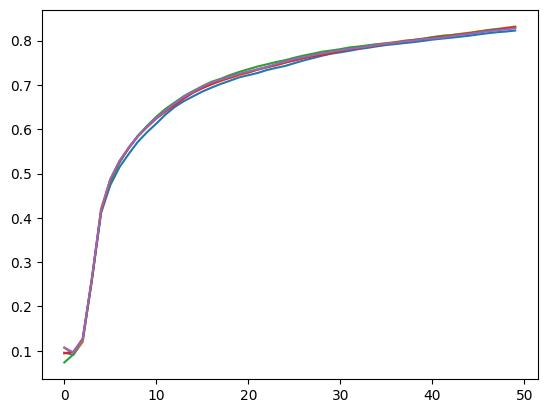

In [15]:
plt.plot(train_accuracies)

In [16]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [17]:
result["train_accuracies"] = train_accuracies
result["train_losses"] = losses
result["test_accuracies"] = test_accuracies
result["test_losses"] = test_losses
result["f1_scores"] = f1_scores
result["ypred_test"] = f1_y_test
result["ylabels_test"] = f1_y_label
result["time_taken"] = time_FL_SMPC
result["f1_global"] = f1_global

In [18]:
my_pickle_results["fedavg"] = result

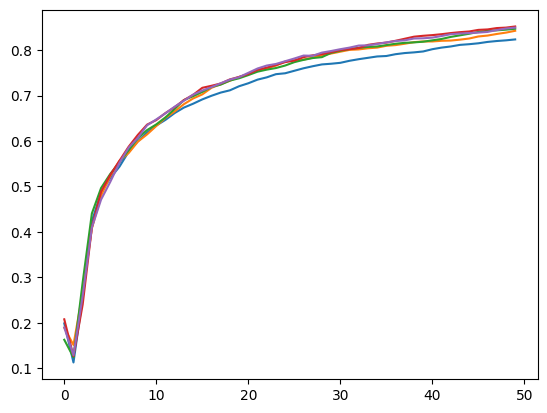

In [19]:
plt.plot(test_accuracies)

In [20]:
print(losses)

[[2.3084499835968018, 2.315432071685791, 2.3102126121520996, 2.314167022705078, 2.2995386123657227], [2.300621509552002, 2.300234317779541, 2.3006224632263184, 2.2999510765075684, 2.300208568572998], [2.2889316082000732, 2.2884514331817627, 2.288795232772827, 2.288264274597168, 2.2884652614593506], [2.2753307819366455, 2.2746682167053223, 2.275010347366333, 2.2746267318725586, 2.274759292602539], [2.2596843242645264, 2.2588388919830322, 2.2591753005981445, 2.2589497566223145, 2.2590091228485107], [2.2417962551116943, 2.240781545639038, 2.241117477416992, 2.241008758544922, 2.240995407104492], [2.221675395965576, 2.2204647064208984, 2.2208118438720703, 2.2208120822906494, 2.2207281589508057], [2.1998395919799805, 2.198380470275879, 2.1987173557281494, 2.1988048553466797, 2.198690414428711], [2.1766507625579834, 2.174961566925049, 2.175261974334717, 2.1754465103149414, 2.1752967834472656], [2.152061939239502, 2.150142192840576, 2.150398015975952, 2.150689125061035, 2.150491952896118], [2

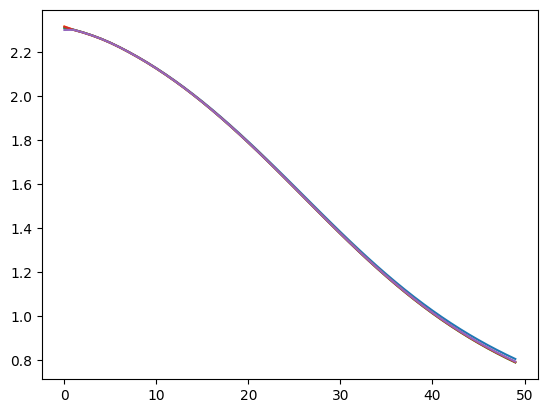

In [21]:
plt.plot(losses)

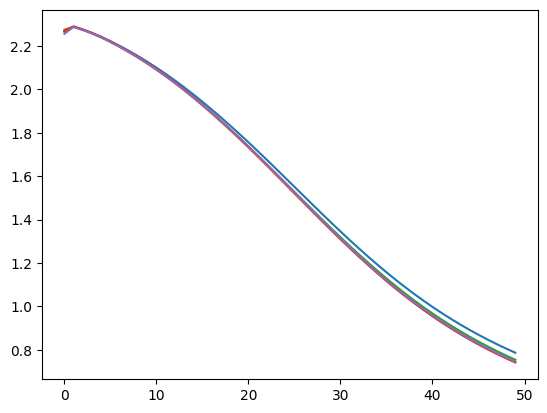

In [22]:
plt.plot(test_losses)

In [23]:

nodes = []
ypred_test = []
ylabels_test = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [24]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc =[]
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):

        node.testing()
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)
    
    av_state = {}
    
    
    
    states = [i.network.state_dict() for i in nodes]
    av_state = {}
    for key in states[0]:
        av_state[key] = sum([s[key] for s in states])/num_nodes
    for node in nodes:
        node.network.load_state_dict(av_state)

time_FL = time.time() - start_time

print("Time taken by FL without SMPC", time_FL)
    

  0%|          | 0/50 [00:00<?, ?it/s]

DEBUG: 0 0.08125 975 12000
DEBUG: 1 0.11191666666666666 1343 12000
DEBUG: 2 0.071 852 12000
DEBUG: 3 0.10433333333333333 1252 12000
DEBUG: 4 0.10333333333333333 1240 12000


  2%|▏         | 1/50 [00:08<07:19,  8.98s/it]

DEBUG: 0 0.15458333333333332 1855 12000
DEBUG: 1 0.15516666666666667 1862 12000
DEBUG: 2 0.1575 1890 12000
DEBUG: 3 0.15775 1893 12000
DEBUG: 4 0.15883333333333333 1906 12000


  4%|▍         | 2/50 [00:17<07:06,  8.88s/it]

DEBUG: 0 0.23508333333333334 2821 12000
DEBUG: 1 0.23866666666666667 2864 12000
DEBUG: 2 0.23933333333333334 2872 12000
DEBUG: 3 0.244 2928 12000
DEBUG: 4 0.241 2892 12000


  6%|▌         | 3/50 [00:26<06:55,  8.84s/it]

DEBUG: 0 0.36475 4377 12000
DEBUG: 1 0.37041666666666667 4445 12000
DEBUG: 2 0.3720833333333333 4465 12000
DEBUG: 3 0.36875 4425 12000
DEBUG: 4 0.37116666666666664 4454 12000


  8%|▊         | 4/50 [00:35<06:51,  8.94s/it]

DEBUG: 0 0.4111666666666667 4934 12000
DEBUG: 1 0.41791666666666666 5015 12000
DEBUG: 2 0.4166666666666667 5000 12000
DEBUG: 3 0.4196666666666667 5036 12000
DEBUG: 4 0.41641666666666666 4997 12000


 10%|█         | 5/50 [00:47<07:27,  9.94s/it]

DEBUG: 0 0.46225 5547 12000
DEBUG: 1 0.46491666666666664 5579 12000
DEBUG: 2 0.4681666666666667 5618 12000
DEBUG: 3 0.466 5592 12000
DEBUG: 4 0.47 5640 12000


 12%|█▏        | 6/50 [00:58<07:41, 10.49s/it]

DEBUG: 0 0.52375 6285 12000
DEBUG: 1 0.52425 6291 12000
DEBUG: 2 0.5295833333333333 6355 12000
DEBUG: 3 0.5305833333333333 6367 12000
DEBUG: 4 0.5310833333333334 6373 12000


 14%|█▍        | 7/50 [01:08<07:17, 10.16s/it]

DEBUG: 0 0.5648333333333333 6778 12000
DEBUG: 1 0.5610833333333334 6733 12000
DEBUG: 2 0.56625 6795 12000
DEBUG: 3 0.5685833333333333 6823 12000
DEBUG: 4 0.57225 6867 12000


 16%|█▌        | 8/50 [01:17<06:53,  9.85s/it]

DEBUG: 0 0.58825 7059 12000
DEBUG: 1 0.58475 7017 12000
DEBUG: 2 0.589 7068 12000
DEBUG: 3 0.5889166666666666 7067 12000
DEBUG: 4 0.592 7104 12000


 18%|█▊        | 9/50 [01:26<06:34,  9.63s/it]

DEBUG: 0 0.6073333333333333 7288 12000
DEBUG: 1 0.59825 7179 12000
DEBUG: 2 0.6080833333333333 7297 12000
DEBUG: 3 0.607 7284 12000
DEBUG: 4 0.609 7308 12000


 20%|██        | 10/50 [01:35<06:17,  9.45s/it]

DEBUG: 0 0.62375 7485 12000
DEBUG: 1 0.6171666666666666 7406 12000
DEBUG: 2 0.6235 7482 12000
DEBUG: 3 0.627 7524 12000
DEBUG: 4 0.6259166666666667 7511 12000


 22%|██▏       | 11/50 [01:45<06:07,  9.43s/it]

DEBUG: 0 0.642 7704 12000
DEBUG: 1 0.6361666666666667 7634 12000
DEBUG: 2 0.6400833333333333 7681 12000
DEBUG: 3 0.6453333333333333 7744 12000
DEBUG: 4 0.64275 7713 12000


 24%|██▍       | 12/50 [01:54<05:54,  9.33s/it]

DEBUG: 0 0.658 7896 12000
DEBUG: 1 0.6530833333333333 7837 12000
DEBUG: 2 0.6578333333333334 7894 12000
DEBUG: 3 0.6593333333333333 7912 12000
DEBUG: 4 0.6603333333333333 7924 12000


 26%|██▌       | 13/50 [02:03<05:47,  9.39s/it]

DEBUG: 0 0.6724166666666667 8069 12000
DEBUG: 1 0.66925 8031 12000
DEBUG: 2 0.6725833333333333 8071 12000
DEBUG: 3 0.672 8064 12000
DEBUG: 4 0.6733333333333333 8080 12000


 28%|██▊       | 14/50 [02:13<05:36,  9.34s/it]

DEBUG: 0 0.685 8220 12000
DEBUG: 1 0.6814166666666667 8177 12000
DEBUG: 2 0.6875 8250 12000
DEBUG: 3 0.6834166666666667 8201 12000
DEBUG: 4 0.6873333333333334 8248 12000


 30%|███       | 15/50 [02:22<05:24,  9.27s/it]

DEBUG: 0 0.6966666666666667 8360 12000
DEBUG: 1 0.6935 8322 12000
DEBUG: 2 0.6996666666666667 8396 12000
DEBUG: 3 0.6976666666666667 8372 12000
DEBUG: 4 0.6975 8370 12000


 32%|███▏      | 16/50 [02:31<05:12,  9.18s/it]

DEBUG: 0 0.7064166666666667 8477 12000
DEBUG: 1 0.70475 8457 12000
DEBUG: 2 0.70875 8505 12000
DEBUG: 3 0.7075 8490 12000
DEBUG: 4 0.7070833333333333 8485 12000


 34%|███▍      | 17/50 [02:40<05:03,  9.21s/it]

DEBUG: 0 0.7135833333333333 8563 12000
DEBUG: 1 0.7135833333333333 8563 12000
DEBUG: 2 0.71675 8601 12000
DEBUG: 3 0.7176666666666667 8612 12000
DEBUG: 4 0.7154166666666667 8585 12000


 36%|███▌      | 18/50 [02:49<04:55,  9.22s/it]

DEBUG: 0 0.7204166666666667 8645 12000
DEBUG: 1 0.7214166666666667 8657 12000
DEBUG: 2 0.7251666666666666 8702 12000
DEBUG: 3 0.724 8688 12000
DEBUG: 4 0.72175 8661 12000


 38%|███▊      | 19/50 [02:58<04:44,  9.17s/it]

DEBUG: 0 0.7260833333333333 8713 12000
DEBUG: 1 0.7269166666666667 8723 12000
DEBUG: 2 0.73175 8781 12000
DEBUG: 3 0.72925 8751 12000
DEBUG: 4 0.7278333333333333 8734 12000


 40%|████      | 20/50 [03:07<04:33,  9.12s/it]

DEBUG: 0 0.7323333333333333 8788 12000
DEBUG: 1 0.73325 8799 12000
DEBUG: 2 0.7369166666666667 8843 12000
DEBUG: 3 0.7334166666666667 8801 12000
DEBUG: 4 0.7339166666666667 8807 12000


 42%|████▏     | 21/50 [03:16<04:23,  9.08s/it]

DEBUG: 0 0.7363333333333333 8836 12000
DEBUG: 1 0.7383333333333333 8860 12000
DEBUG: 2 0.7421666666666666 8906 12000
DEBUG: 3 0.7380833333333333 8857 12000
DEBUG: 4 0.7395 8874 12000


 44%|████▍     | 22/50 [03:25<04:12,  9.02s/it]

DEBUG: 0 0.7415 8898 12000
DEBUG: 1 0.7430833333333333 8917 12000
DEBUG: 2 0.74725 8967 12000
DEBUG: 3 0.7435833333333334 8923 12000
DEBUG: 4 0.7449166666666667 8939 12000


 46%|████▌     | 23/50 [03:34<04:02,  8.98s/it]

DEBUG: 0 0.74675 8961 12000
DEBUG: 1 0.7496666666666667 8996 12000
DEBUG: 2 0.7520833333333333 9025 12000
DEBUG: 3 0.7489166666666667 8987 12000
DEBUG: 4 0.7494166666666666 8993 12000


 48%|████▊     | 24/50 [03:43<03:52,  8.95s/it]

DEBUG: 0 0.75175 9021 12000
DEBUG: 1 0.75525 9063 12000
DEBUG: 2 0.7558333333333334 9070 12000
DEBUG: 3 0.7541666666666667 9050 12000
DEBUG: 4 0.7546666666666667 9056 12000


 50%|█████     | 25/50 [03:52<03:44,  8.97s/it]

DEBUG: 0 0.75725 9087 12000
DEBUG: 1 0.76175 9141 12000
DEBUG: 2 0.76025 9123 12000
DEBUG: 3 0.7581666666666667 9098 12000
DEBUG: 4 0.7608333333333334 9130 12000


 52%|█████▏    | 26/50 [04:01<03:34,  8.95s/it]

DEBUG: 0 0.7624166666666666 9149 12000
DEBUG: 1 0.766 9192 12000
DEBUG: 2 0.76475 9177 12000
DEBUG: 3 0.764 9168 12000
DEBUG: 4 0.7646666666666667 9176 12000


 54%|█████▍    | 27/50 [04:10<03:25,  8.92s/it]

DEBUG: 0 0.7673333333333333 9208 12000
DEBUG: 1 0.7706666666666667 9248 12000
DEBUG: 2 0.76875 9225 12000
DEBUG: 3 0.7696666666666667 9236 12000
DEBUG: 4 0.7695 9234 12000


 56%|█████▌    | 28/50 [04:18<03:16,  8.91s/it]

DEBUG: 0 0.7718333333333334 9262 12000
DEBUG: 1 0.774 9288 12000
DEBUG: 2 0.774 9288 12000
DEBUG: 3 0.7753333333333333 9304 12000
DEBUG: 4 0.77325 9279 12000


 58%|█████▊    | 29/50 [04:27<03:06,  8.90s/it]

DEBUG: 0 0.7760833333333333 9313 12000
DEBUG: 1 0.7793333333333333 9352 12000
DEBUG: 2 0.7798333333333334 9358 12000
DEBUG: 3 0.7795 9354 12000
DEBUG: 4 0.77725 9327 12000


 60%|██████    | 30/50 [04:36<02:58,  8.93s/it]

DEBUG: 0 0.7806666666666666 9368 12000
DEBUG: 1 0.7825 9390 12000
DEBUG: 2 0.7846666666666666 9416 12000
DEBUG: 3 0.7840833333333334 9409 12000
DEBUG: 4 0.7804166666666666 9365 12000


 62%|██████▏   | 31/50 [04:45<02:49,  8.92s/it]

DEBUG: 0 0.7855 9426 12000
DEBUG: 1 0.78625 9435 12000
DEBUG: 2 0.7876666666666666 9452 12000
DEBUG: 3 0.7869166666666667 9443 12000
DEBUG: 4 0.7846666666666666 9416 12000


 64%|██████▍   | 32/50 [04:54<02:40,  8.91s/it]

DEBUG: 0 0.7899166666666667 9479 12000
DEBUG: 1 0.7884166666666667 9461 12000
DEBUG: 2 0.79125 9495 12000
DEBUG: 3 0.7914166666666667 9497 12000
DEBUG: 4 0.7891666666666667 9470 12000


 66%|██████▌   | 33/50 [05:03<02:32,  8.95s/it]

DEBUG: 0 0.79425 9531 12000
DEBUG: 1 0.7915833333333333 9499 12000
DEBUG: 2 0.7945 9534 12000
DEBUG: 3 0.79375 9525 12000
DEBUG: 4 0.7925833333333333 9511 12000


 68%|██████▊   | 34/50 [05:12<02:22,  8.93s/it]

DEBUG: 0 0.7964166666666667 9557 12000
DEBUG: 1 0.7938333333333333 9526 12000
DEBUG: 2 0.7975 9570 12000
DEBUG: 3 0.7978333333333333 9574 12000
DEBUG: 4 0.7955833333333333 9547 12000


 70%|███████   | 35/50 [05:21<02:13,  8.93s/it]

DEBUG: 0 0.79825 9579 12000
DEBUG: 1 0.7975 9570 12000
DEBUG: 2 0.8005 9606 12000
DEBUG: 3 0.8016666666666666 9620 12000
DEBUG: 4 0.7998333333333333 9598 12000


 72%|███████▏  | 36/50 [05:30<02:04,  8.93s/it]

DEBUG: 0 0.8004166666666667 9605 12000
DEBUG: 1 0.8008333333333333 9610 12000
DEBUG: 2 0.8038333333333333 9646 12000
DEBUG: 3 0.8035833333333333 9643 12000
DEBUG: 4 0.80175 9621 12000


 74%|███████▍  | 37/50 [05:39<01:56,  8.97s/it]

DEBUG: 0 0.8013333333333333 9616 12000
DEBUG: 1 0.8035 9642 12000
DEBUG: 2 0.8074166666666667 9689 12000
DEBUG: 3 0.806 9672 12000
DEBUG: 4 0.8045 9654 12000


 76%|███████▌  | 38/50 [05:48<01:47,  8.94s/it]

DEBUG: 0 0.8038333333333333 9646 12000
DEBUG: 1 0.8064166666666667 9677 12000
DEBUG: 2 0.81 9720 12000
DEBUG: 3 0.8088333333333333 9706 12000
DEBUG: 4 0.8069166666666666 9683 12000


 78%|███████▊  | 39/50 [05:57<01:38,  8.92s/it]

DEBUG: 0 0.8056666666666666 9668 12000
DEBUG: 1 0.8083333333333333 9700 12000
DEBUG: 2 0.81225 9747 12000
DEBUG: 3 0.8109166666666666 9731 12000
DEBUG: 4 0.8095 9714 12000


 80%|████████  | 40/50 [06:06<01:29,  8.91s/it]

DEBUG: 0 0.8078333333333333 9694 12000
DEBUG: 1 0.8119166666666666 9743 12000
DEBUG: 2 0.8139166666666666 9767 12000
DEBUG: 3 0.8130833333333334 9757 12000
DEBUG: 4 0.812 9744 12000


 82%|████████▏ | 41/50 [06:15<01:20,  8.92s/it]

DEBUG: 0 0.8105833333333333 9727 12000
DEBUG: 1 0.8145 9774 12000
DEBUG: 2 0.81625 9795 12000
DEBUG: 3 0.8156666666666667 9788 12000
DEBUG: 4 0.8143333333333334 9772 12000


 84%|████████▍ | 42/50 [06:24<01:11,  8.96s/it]

DEBUG: 0 0.8125 9750 12000
DEBUG: 1 0.8160833333333334 9793 12000
DEBUG: 2 0.8176666666666667 9812 12000
DEBUG: 3 0.8175833333333333 9811 12000
DEBUG: 4 0.8154166666666667 9785 12000


 86%|████████▌ | 43/50 [06:33<01:02,  8.94s/it]

DEBUG: 0 0.8144166666666667 9773 12000
DEBUG: 1 0.8181666666666667 9818 12000
DEBUG: 2 0.8196666666666667 9836 12000
DEBUG: 3 0.8195 9834 12000
DEBUG: 4 0.81825 9819 12000


 88%|████████▊ | 44/50 [06:41<00:53,  8.92s/it]

DEBUG: 0 0.8163333333333334 9796 12000
DEBUG: 1 0.8194166666666667 9833 12000
DEBUG: 2 0.8213333333333334 9856 12000
DEBUG: 3 0.8213333333333334 9856 12000
DEBUG: 4 0.8190833333333334 9829 12000


 90%|█████████ | 45/50 [06:50<00:44,  8.95s/it]

DEBUG: 0 0.8185 9822 12000
DEBUG: 1 0.8210833333333334 9853 12000
DEBUG: 2 0.82175 9861 12000
DEBUG: 3 0.8234166666666667 9881 12000
DEBUG: 4 0.821 9852 12000


 92%|█████████▏| 46/50 [07:00<00:36,  9.00s/it]

DEBUG: 0 0.82075 9849 12000
DEBUG: 1 0.8234166666666667 9881 12000
DEBUG: 2 0.8236666666666667 9884 12000
DEBUG: 3 0.8258333333333333 9910 12000
DEBUG: 4 0.8234166666666667 9881 12000


 94%|█████████▍| 47/50 [07:09<00:27,  9.22s/it]

DEBUG: 0 0.8226666666666667 9872 12000
DEBUG: 1 0.8255833333333333 9907 12000
DEBUG: 2 0.8259166666666666 9911 12000
DEBUG: 3 0.8274166666666667 9929 12000
DEBUG: 4 0.82425 9891 12000


 96%|█████████▌| 48/50 [07:19<00:18,  9.23s/it]

DEBUG: 0 0.8245833333333333 9895 12000
DEBUG: 1 0.8279166666666666 9935 12000
DEBUG: 2 0.8274166666666667 9929 12000
DEBUG: 3 0.8299166666666666 9959 12000
DEBUG: 4 0.8265 9918 12000


 98%|█████████▊| 49/50 [07:30<00:09,  9.79s/it]

DEBUG: 0 0.8265833333333333 9919 12000
DEBUG: 1 0.8305833333333333 9967 12000
DEBUG: 2 0.8296666666666667 9956 12000
DEBUG: 3 0.8320833333333333 9985 12000
DEBUG: 4 0.8284166666666667 9941 12000


100%|██████████| 50/50 [07:41<00:00,  9.22s/it]

Time taken by FL without SMPC 461.16300773620605


In [25]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [26]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)

0.8380540898574456


In [27]:
train_accuracies[0]

[0.08125, 0.11191666666666666, 0.071, 0.10433333333333333, 0.10333333333333333]

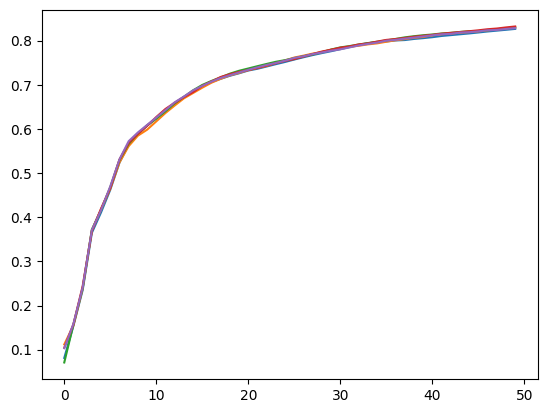

In [28]:
plt.plot(train_accuracies)

In [29]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [30]:
global_mean = 0.0
global_std = 0.0
eqn1= 0.0 
eqn2 = 0.0
eqn3 = 0.0
for node in nodes:
    eqn1 += node.mean * node.dataset_size
    eqn2 += node.dataset_size 
    eqn3 += node.std


global_mean = eqn1/eqn2
global_std = eqn3/eqn2
print("Global Mean", global_mean.shape)
print("Global std ", global_std.shape)
#plt.imshow(global_mean.squeeze())
#plt.imshow(global_std.squeeze())

Global Mean torch.Size([1, 28, 28])
Global std  torch.Size([1, 28, 28])


In [31]:
result2["train_accuracies"] = train_accuracies
result2["train_losses"] = losses
result2["test_accuracies"] = test_accuracies
result2["test_losses"] = test_losses
result2["f1_scores"] = f1_scores
result2["ypred"] = ypred
result2["ylabels"] = ylabels
result2["ypred_test"] = ypred_test
result2["ylabels_test"] = ylabels_test
result2["time_taken"] = time_FL
result2["f1_global"] = f1_global

In [32]:
my_pickle_results["vanilla"] = result2
#print(my_pickle_results)
# pickle.dumps(my_pickle_results)
print(my_pickle_results["vanilla"]["time_taken"])

461.16300773620605


In [33]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

[tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])]


In [35]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-14 13:59:44
